# Kaggle Mini-Project: Disaster Tweets

<https://www.kaggle.com/competitions/nlp-getting-started/overview>

Neil Chen, University of Colorado Boulder

Mar 30, 2025

## 1. Brief Description

Disaster Tweets is a Kaggle project to predict which tweets are about real disasters and which ones are not.

It's a NLP problem, where we need to do binary classification based on tweet texts. The dataset has `7613` samples, which is quite small.

The dataset has a few metadata related columns like `keyword`, `location`, but we won't care much about these, and will only focus on predicting whether a tweet is about a disaster based on the `text` column, and the `target` column contains 0/1 labels for the training dataset.

Speaking of NLP, I took some training by following this tutorial to get my self familiar with basic concepts and training procedures: <https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial>.

For a NLP task, first we will need to tokenize the text into words, and then can transform the word statistics data into vectors. There are several techniques for text vectorization, like simple counting, TF/IDF etc.

Then we can design a model to do the training.
I will first try with a linear regression model as the baseline, and then try with more advanced deep learning models like LSTM and so on, because text are sequential data, with such models hopefully it can learn the underlying meanings (whether it is about a disaster or not) of the text.

In [127]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
from nltk.stem import PorterStemmer

## 2. Exploratory Data Analysis (EDA)

In [128]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

Check the training data:

In [129]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [130]:
# Check null values
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

We can see that the null values only exist in `location` and `keyword` columns, but since we won't do training based on these columns, it doesn't matter.

Next we check the test data:

In [131]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


So now we have 7613 samples of training data, and 3263 samples of test data.

Now let's take a look at what does a non-disaster related tweet look like:

In [132]:
train_df[train_df["target"] == 0]["text"].values[2]

'Summer is lovely'

and what does a disaster related tweet look like:

In [133]:
train_df[train_df["target"] == 1]["text"].values[3]

'13,000 people receive #wildfires evacuation orders in California '

Next let's check whether the `target` value in the training data has evenly distributed number of 0 or 1 values:

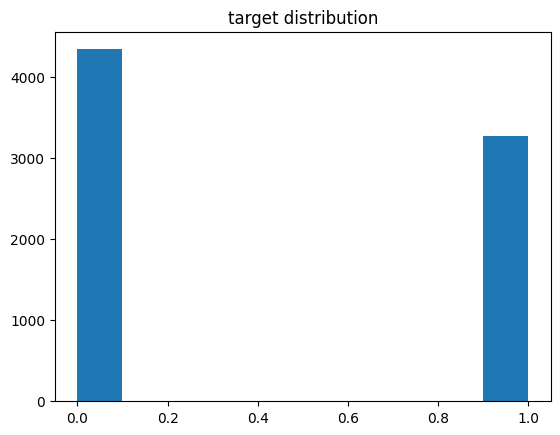

In [134]:
train_df['target'].value_counts(normalize=True)

plt.hist(train_df['target'])
plt.title('target distribution')
plt.show()

So the distribution is quite even, which is good for the training.

We can also check about the top-10 `keyword` and `location` data to get some intuition of the data.

Text(0.5, 1.0, 'Top 10 Keywords by Count')

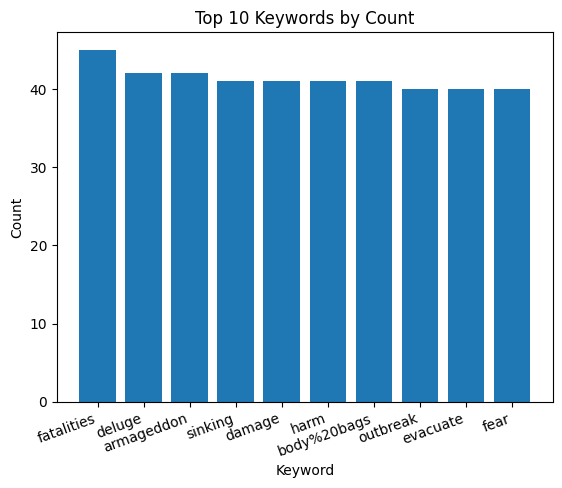

In [135]:
# Check keywords
top_10_keywords = train_df['keyword'].value_counts().head(10)
plt.bar(top_10_keywords.index.tolist(), top_10_keywords.values.tolist())
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=20, ha='right') # Rotate the x labels to avoid collision
plt.title('Top 10 Keywords by Count')

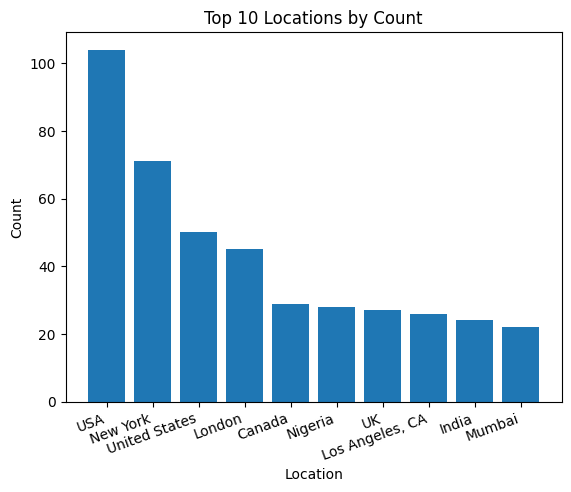

In [84]:
# Check top 10 locations
top_10_locations = train_df.location.value_counts().head(10)
plt.bar(top_10_locations.index.tolist(), top_10_locations.values.tolist() )
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=20, ha='right') # Rotate the x labels to avoid collision
plt.title('Top 10 Locations by Count')
plt.show()

We can also check text length distributions:

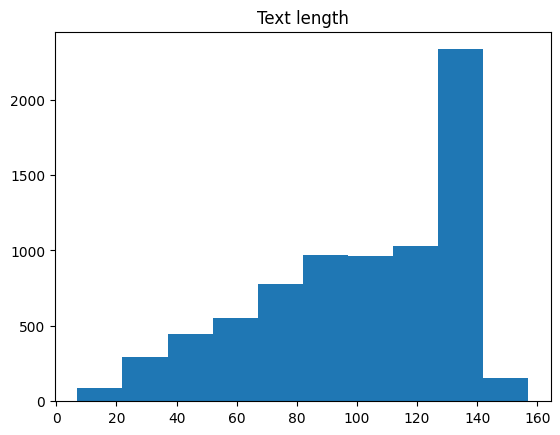

In [136]:
# Check text length distribution
text_len = [len(txt) for txt in train_df['text']]
plt.hist(text_len)
plt.title('Text length')
plt.show()

and count of words distribution as well,

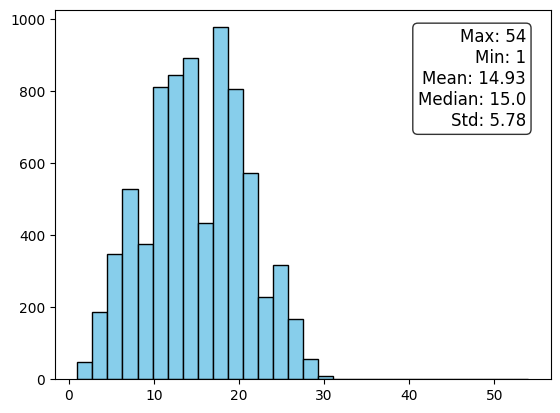

In [137]:
# Check count of words distribution
count_words = [len(txt.split(' ')) for txt in train_df['text']]

max_words = max(count_words)
min_words = min(count_words)
mean_words = np.mean(count_words)
median_words = np.median(count_words)
std_words = np.std(count_words)

stats_text = f'Max: {max_words}\nMin: {min_words}\nMean: {mean_words:.2f}\nMedian: {median_words}\nStd: {std_words:.2f}'
plt.hist(count_words, bins=30, color='skyblue', edgecolor='black')
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

We see that the count of words in a tweet is less than 30, and the distribution looks normal.


## Preprocessing: Vectorize the text data

Now let's try with the `CountVectorizer` first.

In [138]:
# Building vectors
count_vectorizer = feature_extraction.text.CountVectorizer()

# get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

In [139]:
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [140]:
# get counts for the whole training data
train_vectors = count_vectorizer.fit_transform(train_df["text"])
print('Vocabulary size: ', len(count_vectorizer.vocabulary_))

# For test data, we use `transform` instead of `fit_transform`, 
# because we don't want to embed the words from the test dataset, only
# preprocess the test text for prediction purpose
test_vectors = count_vectorizer.transform(test_df["text"])

Vocabulary size:  21637


The vocabulary size might be a bit large (ideally 5k ~ 15k), but we will train this data first as a baseline and revisit later, to see if applying some preprocessing helps, like excluding stop words and so on.

## 3. Model Architecture

### Baseline Model: RidgeClassifier

Let's first use a standard `RidgeClassifier` as baseline model, which is a linear regression model.

In [141]:
clf = linear_model.RidgeClassifier()

In [142]:
# Evaluate a score by cross validation
# cv=3 means 3-fold
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.59453669, 0.5642787 , 0.64082434])

In [143]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier()

Apply the model to predict test data.

In [144]:
clf.predict(test_vectors)

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

### More Advanced Deep Learning Models

### LSTM

In [145]:
# Expand dimensions by adding a time dimension. The resulting shape is (7613, 1, features)
train_vectors = train_vectors.todense()
train_vectors = np.expand_dims(train_vectors, axis=1)

X_train, X_val, y_train, y_val = train_test_split(train_vectors, train_df['target'], test_size=0.2, random_state=42)

In [ ]:
# We will reuse this function many times to evaluate a model over validation data,
# and also do visualizations
def evaluate(model, X_val, y_val, history):
    # evaluate on validation data
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f'Validation Loss: , {loss:.4f}')
    print(f'Validation Accuracy: {accuracy:.4f}')

    # visulization
    plt.figure(figsize=(12, 4))

    # render train loss and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # render train accuracy and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               11144192  
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 11,152,513
Trainable params: 11,152,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [=====================

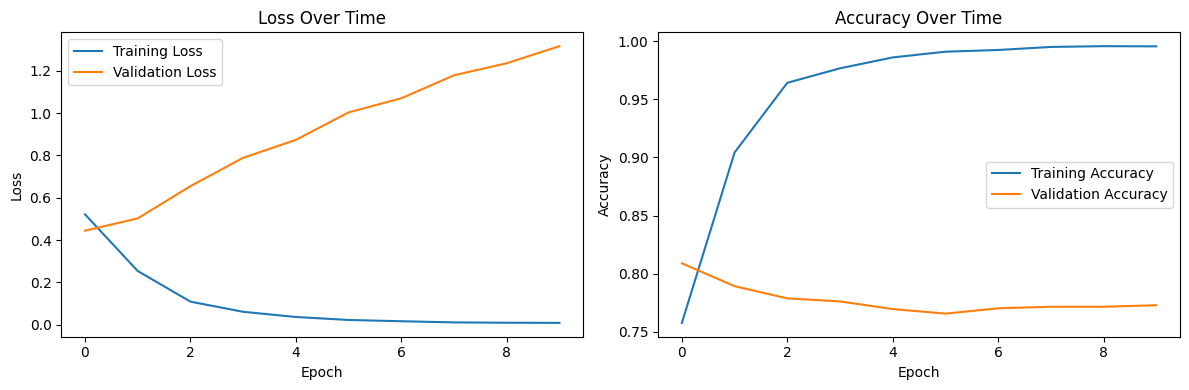

In [147]:
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=128, input_shape=(train_vectors.shape[1], train_vectors.shape[2]),
               return_sequences=False)) # only return the output of the last step

# Avoid overfitting
model.add(Dropout(0.2))

# Add fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer, use sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# train
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

evaluate(model, X_val, y_val, history)

In [103]:
print("train_vectors shape:", train_vectors.shape)
print("train_vectors type:", type(train_vectors))

train_vectors shape: (7613, 1, 21637)
train_vectors type: <class 'numpy.ndarray'>


## 4. Result and Analysis

The final validation accuracy is `77%`, but as the validation loss increases, the model overfits very quickly.

### Improvement: Data Cleaning

Now let's try to do some data cleaning to see if it improves:

1. Normalize the text to all lower case, to avoid duplications in the vocabulary.
2. Remove stop words
3. Remove punctuations and numbers
4. Apply stemming of the words (for example: 'running' -> 'run')
5. Exclude the noise words which only appear once, to exclude typos or rare words.


In [148]:
def my_clean_text(text):
    text = text.lower() # to lower
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuations
    text = re.sub(r'\d+', '', text)  # remove numbers
    
    # stem text
    ps = PorterStemmer()
    text = ' '.join(ps.stem(word) for word in text.split())
    return text

# clean text
cleaned_texts = train_df['text'].apply(my_clean_text)

# vectorize
vectorizer = feature_extraction.text.CountVectorizer(stop_words='english', min_df=2) # min_df helps exclude rare words
train_vectors = vectorizer.fit_transform(cleaned_texts)
print("Vocabulary size after cleaning:", len(vectorizer.vocabulary_))


Vocabulary size after cleaning: 5165


The vocabulary is much smaller than before, which looks good! Let's try out the model again.

In [149]:
# Expand dimensions by adding a time dimension. The resulting shape is (7613, 1, features)
train_vectors = train_vectors.todense()
train_vectors = np.expand_dims(train_vectors, axis=1)

X_train, X_val, y_train, y_val = train_test_split(train_vectors, train_df['target'], test_size=0.2, random_state=42)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 128)               2710528   
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,718,849
Trainable params: 2,718,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [=======================

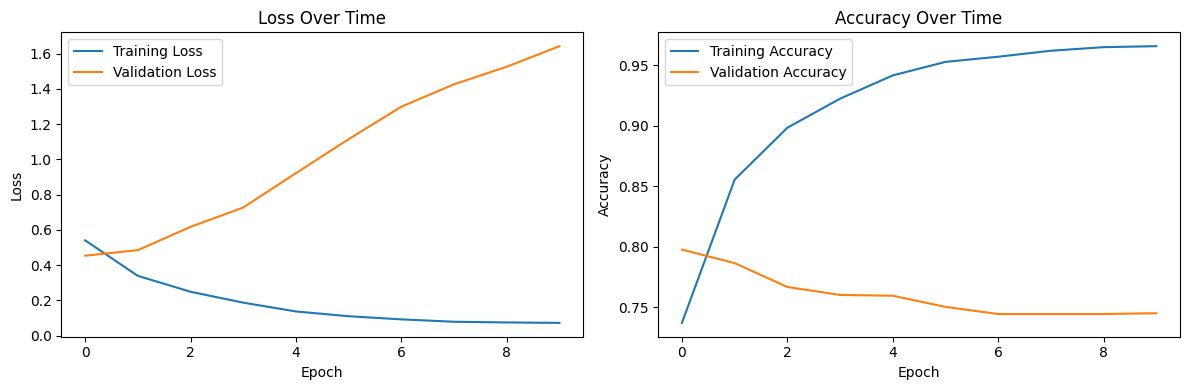

In [150]:
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=128, input_shape=(train_vectors.shape[1], train_vectors.shape[2]),
               return_sequences=False)) # only return the output of the last step

# Avoid overfitting
model.add(Dropout(0.2))

# Add fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer, use sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# train
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

# evaluation
evaluate(model, X_val, y_val, history)

The validation loss is still going up, which means the model overfits, and the validation accuracy is at 74%, not good.

### Model Tuning

There might be a few reasons for the overfit and not so good performance.

1. It's possible that some useful information is removed. For example some low frequency words, or useful stop words like 'not'.
2. The method for vectorizer is not good enough. We choosed `CountVectorizer` which is based on "bag of words" counting, which essentially trains on static data, and can not learn sequential information.
3. **Hyper-parameters** may need some tuning:
   1. The number of cells in the LSTM model might be too large for this small dataset. (currently it is 128)
   2. Dropout rate 0.2 might be not enough.
   3. Learning rate can be tuned.

 
#### Optimize 1: Use Tokenizer + Embedding to replace CountVectorizer, which can preserve word ordering information

With this approach, we will use the tokenizer to build a corpus over the training data;
and then transform the text into sequences (of token ids).
Also, we will need to pad the sequences to make sure all the samples are transformed to the same number of tokens.

(Here is a great explaination of tokenization and sequencing:
<https://dev.to/balapriya/tokenization-and-sequencing-in-tensorflow-3p0n>)

In [159]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['text'])

# convert text to token sequences
sequences = tokenizer.texts_to_sequences(train_df['text'])
train_vectors = pad_sequences(sequences, maxlen=54) # limit the maxlen to 54, we got this information through previous EDA
print('New shape: ', train_vectors.shape)

New shape:  (7613, 54)


In [162]:
# model
model = Sequential()

# Embedding layer: input_dim=5000, output_dim=128
model.add(Embedding(5000, 128, input_length=54))

# Add LSTM layers
model.add(LSTM(units=128, return_sequences=False)) # only return the output of the last step

# Avoid overfitting
model.add(Dropout(0.2))

# Add fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer, use sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# model.add(Embedding(5000, 128, input_length=54)) # input_dim=5000, output_dim=128
# model.add(LSTM(64, return_sequences=False))  # LSTM
# model.add(Dropout(0.3)) # to prevent overfitting, increase the dropout rate a little bit
# model.add(Dense(32, activation='relu')) # fully connected layer
# model.add(Dropout(0.3)) # to prevent overfitting
# model.add(Dense(1, activation='sigmoid')) # output layer, binary classifier

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 54, 128)           640000    
                                                                 
 lstm_16 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 779,905
Trainable params: 779,905
Non-t

Epoch 1/10
191/191 [==============================] - 4s 13ms/step - loss: 0.5381 - accuracy: 0.7281 - val_loss: 0.4379 - val_accuracy: 0.8109
Epoch 2/10
191/191 [==============================] - 2s 11ms/step - loss: 0.3435 - accuracy: 0.8578 - val_loss: 0.4545 - val_accuracy: 0.8050
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2630 - accuracy: 0.8995 - val_loss: 0.5567 - val_accuracy: 0.7715
Epoch 4/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2008 - accuracy: 0.9205 - val_loss: 0.5877 - val_accuracy: 0.7597
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.1476 - accuracy: 0.9424 - val_loss: 0.8771 - val_accuracy: 0.7525
Epoch 6/10
191/191 [==============================] - 2s 11ms/step - loss: 0.1034 - accuracy: 0.9581 - val_loss: 0.8943 - val_accuracy: 0.7722
Epoch 7/10
191/191 [==============================] - 2s 11ms/step - loss: 0.0803 - accuracy: 0.9642 - val_loss: 1.1553 - val_accuracy: 0.7623

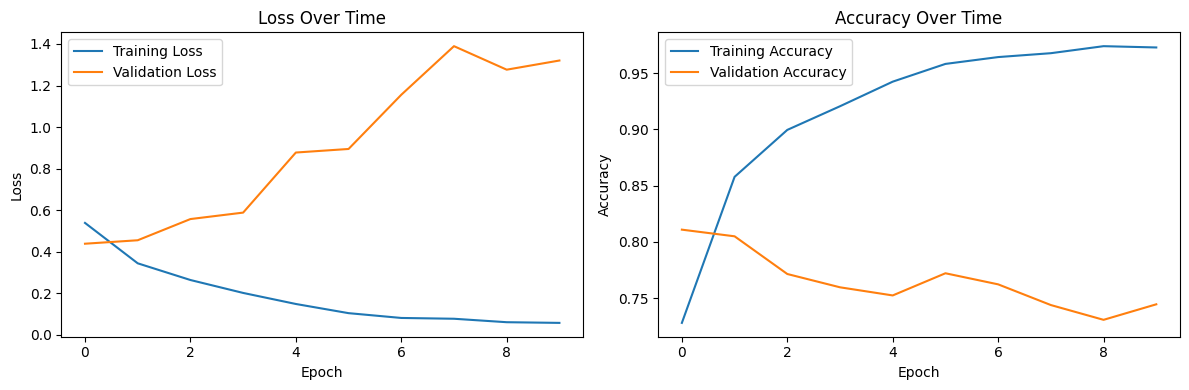

In [163]:
# compile the model
X_train, X_val, y_train, y_val = train_test_split(train_vectors, train_df['target'], test_size=0.2, random_state=42)

# train
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

# evaluation
evaluate(model, X_val, y_val, history)

The situation did not improve, still overfits.

#### Hyper parameter tuning

To migigate overfitting, let's apply some techniques:

- L2 regularization
- smaller model (64 cells)
- smaller learning rate: 0.0001
- bigger drop out rate: 0.5

In [164]:
# Use smaller models, with L2 regularization
model = Sequential()
model.add(Embedding(5000, 128, input_length=54))
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))  # LSTM
model.add(Dropout(0.5)) # to prevent overfitting, increase the dropout rate a little bit
model.add(Dense(32, activation='relu')) # fully connected layer
model.add(Dropout(0.5)) # to prevent overfitting
model.add(Dense(1, activation='sigmoid')) # output layer, binary classifier

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 54, 128)           640000    
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 32)                2080      
                                                                 
 dropout_36 (Dropout)        (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 1)                 33        
                                                                 
Total params: 691,521
Trainable params: 691,521
Non-t

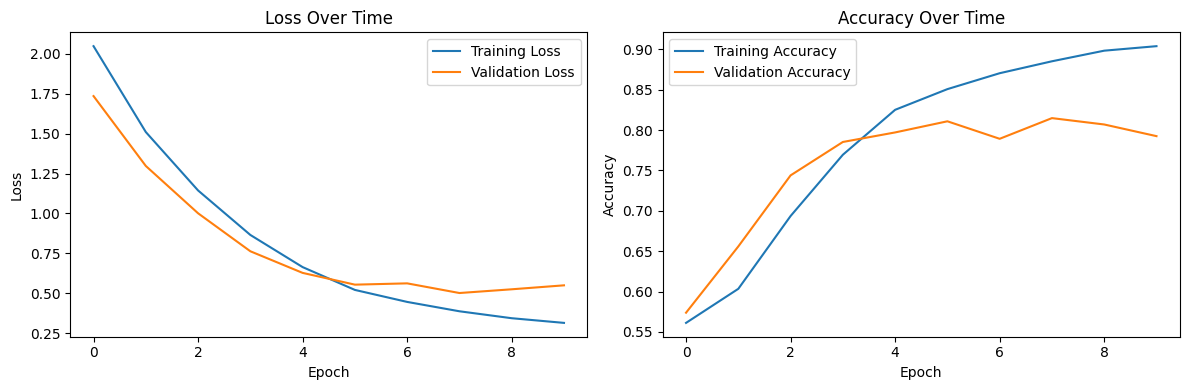

In [165]:
# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

X_train, X_val, y_train, y_val = train_test_split(train_vectors, train_df['target'], test_size=0.2, random_state=42)

# train
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

# evaluation
evaluate(model, X_val, y_val, history)

This worked quite well, since we can now see validation accuracy increases over time, and the validation loss drops.

### Predict on Test Data

Now we can run prediction with the model on test data, and generate the submission file.

In [169]:
# submission = pd.read_csv('./data/sample_submission.csv')
# submission['target'] = model.predict(test_df)

test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_vectors = pad_sequences(test_sequences, maxlen=54)
test_y_prob = model.predict(test_vectors)
test_y = (test_y_prob > 0.5).astype(int) # shape: (n_samples,)
# flatten
test_y = test_y.flatten()

result_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_y
})

# Save to file
result_df.to_csv('submission.csv', index=False)

102/102 [==============================] - 1s 8ms/step


## 5. Conclusions

In this project, I practiced about how to build a NLP model to predict text classification.

First I used a few methods to vectorize the text data, like `CountVectorizer`, and `Tokenizer` with `Embedding`.

Then I train models for it. With simple `RidgeClassifier` I achieved around `60%` accuracy as the baseline model.

and for the more advanced model `LSTM`, I initially got `77%` validation accuracy, but the model is overfitting very quickly.

I tried a few ways including:

- Data cleaning
- Use `Tokenizer` with `Embedding` to replace the simple `CountVectorizer` so that the model can learn sequential information.
- Fewer `LSTM` cells
- Smaller learning rate
- Larger dropout rate

Finally I achived `79%` validation accuracy, with the validation loss going down, which means the model training goes quite well and is not overfitting anymore.


For future explorations, I can try some other approaches to further improve the model:

1. Use pretrained language models like BERT to improve the text embedding part.
2. Improve data cleaning part, with more intersting techniques. For example, as suggested in this [post](https://www.kaggle.com/competitions/nlp-getting-started/discussion/514207), converting the tweet to lower case may lose some information, for example camel case words can be splitted, which preserves more information than simply converting them into lowercase.